<a href="https://colab.research.google.com/github/vkjdinesh/Reseacrh/blob/main/Text_to_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, concatenate
from keras.layers.core import Activation, Flatten
from keras.layers import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
# from keras_text_to_image.library.utility.image_utils import combine_normalized_images, img_from_normalized_img
from keras import backend as K
import numpy as np
from PIL import Image
import sys
import math

## DownLoad the data

In [ ]:


from __future__ import print_function
import os,sys,gzip,requests,zipfile,tarfile
from tqdm import tqdm
from six.moves import urllib
import time

'''
This script is mainly used in cooperation with codes from https://github.com/zsdonghao/text-to-image
download flower dataset from : http://www.robots.ox.ac.uk/~vgg/data/flowers/102/
download caption dataset from : https://drive.google.com/uc?export=download&confirm=l7Ld&id=0B0ywwgffWnLLcms2WWJQRFNSWXM
'''


def get_confirm_token(response):
	for key, value in response.cookies.items():
		if key.startswith('download_warning'):
			return value
	return None

def save_response_content(response, destination, chunk_size=32*1024):
	total_size = int(response.headers.get('content-length', 0))
	with open(destination, "wb") as f:
		for chunk in tqdm(response.iter_content(chunk_size), total=total_size,
				unit='B', unit_scale=True, desc=destination):
			if chunk: # filter out keep-alive new chunks
				f.write(chunk)

def download_file_from_google_drive(id, destination):    
	URL = "https://docs.google.com/uc?export=download"
	session = requests.Session()

	response = session.get(URL, params={ 'id': id }, stream=True)
	token = get_confirm_token(response)

	if token:
		params = { 'id' : id, 'confirm' : token }
		response = session.get(URL, params=params, stream=True)
	save_response_content(response, destination)

def download_caption(dirpath):
	data_dir = 'cvpr2016_flowers.tar.gz'
	if os.path.exists(os.path.join(dirpath, data_dir)):
		print('Found cvpr2016_flowers.tar.gz - skip')
		return

	filename, drive_id  = "cvpr2016_flowers.tar.gz", "0B0ywwgffWnLLcms2WWJQRFNSWXM"
	save_path = os.path.join(dirpath, filename)

	if os.path.exists(save_path):
		print('[*] {} already exists'.format(save_path))
	else:
		download_file_from_google_drive(drive_id, save_path)


def download(url, dirpath):
	filepath = dirpath
	u = urllib.request.urlopen(url)
	f = open(filepath, 'wb')
	filesize = int(u.headers["Content-Length"])
	print("Downloading: %s Bytes: %s" % ("102flowers", filesize))

	downloaded = 0
	block_sz = 8192
	status_width = 70
	while True:
		buf = u.read(block_sz)
		if not buf:
			print('')
			break
		else:
			print('', end='\r')
		downloaded += len(buf)
		f.write(buf)

		status = (("[{}  " + " ***progress: {:03.1f}% ]").format('=' * int(float(downloaded) / 
			filesize * status_width) + '>', downloaded * 100. / filesize))
		print(status, end='')

		sys.stdout.flush()
	f.close()
	return filepath

def unzip(src_dir,new_name = None):
	# extract to current directory
	dirpath = '/content/drive/MyDrive/Text-to-Image/keras-text-to-image/demo/data1'
	try:
		if src_dir.endswith('.zip'):
			print('unzipping ' + src_dir)
			with zipfile.ZipFile(src_dir) as zf:
				zip_dir = zf.namelist()[0]
				zf.extractall(dirpath)
		elif src_dir.endswith('.tgz') or src_dir.endswith('tar.gz'):
			print('unzipping ' + src_dir)
			tar = tarfile.open(src_dir,"r:gz")
			tar.extractall()
			tar.close()
		# os.remove(save_path)
		if new_name is None:
			pass
		else:
			os.rename('jpg', os.path.join(dirpath, new_name))
	except:
		raise('wrong format')

def startDownload():
	url = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
	cur_dir = "/content/drive/MyDrive/Text-to-Image/keras-text-to-image/demo/data1"
	image_dir = os.path.join(cur_dir,"102flowers.tgz")
	if os.path.exists(image_dir):
		print('dataset already exists')
	else:
		download(url,image_dir)
	unzip(image_dir)

	caption_dir = os.path.join(cur_dir,"cvpr2016_flowers.tar.gz")
	if os.path.exists(caption_dir):
		print('dataset already exists')
	else:
		download_caption(cur_dir)
	unzip(caption_dir)



In [ ]:
import tensorflow as tf
import os
import random
import scipy
import scipy.misc
import numpy as np
import re
import string

""" The functions here will be merged into TensorLayer after finishing this project.
"""

def load_and_assign_npz(sess=None, name="", model=None):
    assert model is not None
    assert sess is not None
    if not os.path.exists(name):
        print("[!] Loading {} model failed!".format(name))
        return False
    else:
        params = tl.files.load_npz(name=name)
        tl.files.assign_params(sess, params, model)
        print("[*] Loading {} model SUCCESS!".format(name))
        return model


#files
def load_folder_list(path=""):
    """Return a folder list in a folder by given a folder path.
    Parameters
    ----------
    path : a string or None
        A folder path.
    """
    return [os.path.join(path,o) for o in os.listdir(path) if os.path.isdir(os.path.join(path,o))]

#utils
def print_dict(dictionary={}):
    """Print all keys and items in a dictionary.
    """
    for key, value in dictionary.iteritems():
        print("key: %s  value: %s" % (str(key), str(value)))

#prepro ?
def get_random_int(min=0, max=10, number=5):
    """Return a list of random integer by the given range and quantity.
    Examples
    ---------
    >>> r = get_random_int(min=0, max=10, number=5)
    ... [10, 2, 3, 3, 7]
    """
    return [random.randint(min,max) for p in range(0,number)]

def preprocess_caption(line):
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    return prep_line


## Save images
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

from tensorlayer.prepro import *
def prepro_img(x, mode=None):
    if mode=='train':
    # rescale [0, 255] --> (-1, 1), random flip, crop, rotate
    #   paper 5.1: During mini-batch selection for training we randomly pick
    #   an image view (e.g. crop, flip) of the image and one of the captions
    # flip, rotate, crop, resize : https://github.com/reedscot/icml2016/blob/master/data/donkey_folder_coco.lua
    # flip : https://github.com/paarthneekhara/text-to-image/blob/master/Utils/image_processing.py
        x = flip_axis(x, axis=1, is_random=True)
        x = rotation(x, rg=16, is_random=True, fill_mode='nearest')
            # x = crop(x, wrg=50, hrg=50, is_random=True)
            # x = imresize(x, size=[64, 64], interp='bilinear', mode=None)
        x = imresize(x, size=[64+15, 64+15], interp='bilinear', mode=None)
        x = crop(x, wrg=64, hrg=64, is_random=True)
        x = x / (255. / 2.)
        x = x - 1.
        # x = x * 0.9999
    elif mode=='train_stackGAN':
        x = flip_axis(x, axis=1, is_random=True)
        x = rotation(x, rg=16, is_random=True, fill_mode='nearest')
            # x = crop(x, wrg=50, hrg=50, is_random=True)
            # x = imresize(x, size=[64, 64], interp='bilinear', mode=None)
        x = imresize(x, size=[316, 316], interp='bilinear', mode=None)
        x = crop(x, wrg=256, hrg=256, is_random=True)
        x = x / (255. / 2.)
        x = x - 1.
        # x = x * 0.9999
    elif mode=='rescale':
    # rescale (-1, 1) --> (0, 1) for display
        x = (x + 1.) / 2.
    elif mode=='debug':
        x = flip_axis(x, axis=1, is_random=False)
        # x = rotation(x, rg=16, is_random=False, fill_mode='nearest')
        # x = crop(x, wrg=50, hrg=50, is_random=True)
        # x = imresize(x, size=[64, 64], interp='bilinear', mode=None)
        x = x / 255.
    elif mode=='translation':
        x = x / (255. / 2.)
        x = x - 1.
        # from skimage.filters import gaussian
        # print(x.shape, np.min(x), np.max(x))
        # x = x * 0.9999
        # x = gaussian(x, sigma=0.6, multichannel=True)
    else:
        raise Exception("Not support : %s" % mode)
    return x




def combine_and_save_image_sets(image_sets, directory):
    for i in range(len(image_sets[0])):
        combined_image = []
        for set_no in range(len(image_sets)):
            combined_image.append( image_sets[set_no][i] )
            combined_image.append( np.zeros((image_sets[set_no][i].shape[0], 5, 3)) )
        combined_image = np.concatenate( combined_image, axis = 1 )

        scipy.misc.imsave( os.path.join( directory,  'combined_{}.jpg'.format(i) ), combined_image)

ModuleNotFoundError: ignored

In [ ]:
# !pip install tensorlayer

In [ ]:

import os
import re
import time
import nltk
import re
import string
# import tensorlayer as tl



def getFilesList():

  if True:

      cwd = os.getcwd()
      img_dir = os.path.join(cwd, '102flowers')
      caption_dir = os.path.join(cwd, 'text_c10')
      VOC_FIR = cwd + '/vocab.txt'

      ## load captions
      caption_sub_dir = load_folder_list( caption_dir )
      captions_dict = {}
      processed_capts = []
      name_txt={}


      snum=0
      for sub_dir in caption_sub_dir: 
        files = tl.files.load_file_list(path=sub_dir, regx='^image_[0-9]+\.txt')
        for name in files:
          name_txt[name]=sub_dir+"/"+name
      return name_txt
        # for i, f in enumerate(files):
        #     file_dir = os.path.join(sub_dir, f)
        #     print(file_dir)
              
     



In [ ]:
# text_list
# name_text_list["n"]

In [ ]:
# with open("")
name_text_list=getFilesList()


In [ ]:
import pathlib
data_dir="/content/jpg"
data_dir=pathlib.Path(data_dir)
data_dir
import glob

len(list(data_dir.glob('*.jpg')))

PosixPath('/content/jpg')

8189

## Model

In [ ]:
def load_glove(data_dir_path=None, embedding_dim=None):
    """
    Load the glove models (and download the glove model if they don't exist in the data_dir_path
    :param data_dir_path: the directory path on which the glove model files will be downloaded and store
    :param embedding_dim: the dimension of the word embedding, available dimensions are 50, 100, 200, 300, default is 100
    :return: the glove word embeddings
    """
    if embedding_dim is None:
        embedding_dim = 100

    glove_file_path = data_dir_path + "/glove.6B." + str(embedding_dim) + "d.txt"
    download_glove(data_dir_path, glove_file_path)
    _word2em = {}
    file = open(glove_file_path, mode='rt', encoding='utf8')
    for line in file:
        words = line.strip().split()
        word = words[0]
        embeds = np.array(words[1:], dtype=np.float32)
        _word2em[word] = embeds
    file.close()
    return _word2em

import zipfile
def download_glove(data_dir_path, to_file_path):
    if not os.path.exists(to_file_path):
        if not os.path.exists(data_dir_path):
            os.makedirs(data_dir_path)

        glove_zip = data_dir_path + '/glove.6B.zip'

        if not os.path.exists(glove_zip):
            print('glove file does not exist, downloading from internet')
            urllib.request.urlretrieve(url='http://nlp.stanford.edu/data/glove.6B.zip', filename=glove_zip,
                                       reporthook=reporthook)

        print('unzipping glove file')
        with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
                 zip_ref.extractall("/content/drive/MyDrive/Text-to-Image/keras-text-to-image/demo/very_large_data")
        # zip_ref = zipfile.ZipFile(glove_zip, 'r')
        # zip_ref.extractall('very_large_data')
        # zip_ref.close()

In [ ]:
import urllib.request
import os
import zipfile
import numpy as np







class GloveModel(object):
    """
    Class the provides the glove embedding and document encoding functions
    """
    model_name = 'glove-model'

    def __init__(self):
        self.word2em = None
        self.embedding_dim = None

    def load(self, data_dir_path, embedding_dim=None):
        if embedding_dim is None:
            embedding_dim = 100
        self.embedding_dim = embedding_dim
        self.word2em = load_glove(data_dir_path, embedding_dim)

    def encode_word(self, word):
        w = word.lower()
        if w in self.word2em:
            return self.word2em[w]
        else:
            return np.zeros(shape=(self.embedding_dim, ))

    def encode_docs(self, docs, max_allowed_doc_length=None):
        doc_count = len(docs)
        X = np.zeros(shape=(doc_count, self.embedding_dim))
        max_len = 0
        for doc in docs:
            max_len = max(max_len, len(doc.split(' ')))
        if max_allowed_doc_length is not None:
            max_len = min(max_len, max_allowed_doc_length)
        for i in range(0, doc_count):
            doc = docs[i]
            words = [w.lower() for w in doc.split(' ')]
            length = min(max_len, len(words))
            E = np.zeros(shape=(self.embedding_dim, max_len))
            for j in range(length):
                word = words[j]
                try:
                    E[:, j] = self.word2em[word]
                except KeyError:
                    pass
            X[i, :] = np.sum(E, axis=1)

        return X

    def encode_doc(self, doc, max_allowed_doc_length=None):
      
        # print(doc)
        words = [w.lower() for w in doc.split(' ')]
        max_len = len(words)
        if max_allowed_doc_length is not None:
            max_len = min(len(words), max_allowed_doc_length)
        E = np.zeros(shape=(self.embedding_dim, max_len))
        X = np.zeros(shape=(self.embedding_dim, ))
        for j in range(max_len):
            word = words[j]
            try:
                E[:, j] = self.word2em[word]
            except KeyError:
                pass
        X[:] = np.sum(E, axis=1)
        return X

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, concatenate
from keras.layers.core import Activation, Flatten
from keras.layers import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
# from keras_text_to_image.library.utility.image_utils import combine_normalized_images, img_from_normalized_img
from keras import backend as K
import numpy as np
from PIL import Image



def combine_normalized_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num) / width))
    shape = generated_images.shape[1:]
    image = np.zeros((height * shape[0], width * shape[1], shape[2]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index / width)
        j = index % width
        image[i * shape[0]:(i + 1) * shape[0], j * shape[1]:(j + 1) * shape[1], :] = img
    return image


def img_from_normalized_img(normalized_img):
    image = normalized_img * 127.5 + 127.5
    return Image.fromarray(image.astype(np.uint8))

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, concatenate
from keras.layers.core import Activation, Flatten
from keras.layers import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
# from keras_text_to_image.library.utility.image_utils import combine_normalized_images, img_from_normalized_img
from keras import backend as K
import numpy as np
from PIL import Image
import keras
import os

# from keras_text_to_image.library.utility.glove_loader import GloveModel


class DCGanV3(object):
    model_name = 'dc-gan-v3-flower'

    def __init__(self):
        keras.backend.image_data_format()
        self.generator = None
        self.discriminator = None
        self.model = None
        self.img_width = 64
        self.img_height = 64
        self.img_channels = 1
        self.random_input_dim = 100
        self.text_input_dim = 100
        self.config = None
        self.glove_source_dir_path = './very_large_data'
        self.glove_model = GloveModel()

    @staticmethod
    def get_config_file_path(model_dir_path):
        return os.path.join(model_dir_path, DCGanV3.model_name + '-config.npy')

    @staticmethod
    def get_weight_file_path(model_dir_path, model_type):
        return os.path.join(model_dir_path, DCGanV3.model_name + '-' + model_type + '-weights.h5')

    def create_model(self):
        init_img_width = self.img_width // 4
        init_img_height = self.img_height // 4

        random_input = Input(shape=(self.random_input_dim,))
        text_input1 = Input(shape=(self.text_input_dim,))
        random_dense = Dense(self.random_input_dim)(random_input)
        text_layer1 = Dense(1024)(text_input1)

        merged = concatenate([random_dense, text_layer1])
        generator_layer = Activation('tanh')(merged)

        generator_layer = Dense(128 * init_img_width * init_img_height)(generator_layer)
        generator_layer = BatchNormalization()(generator_layer)
        generator_layer = Activation('tanh')(generator_layer)
        generator_layer = Reshape((init_img_width, init_img_height, 128),
                                  input_shape=(128 * init_img_width * init_img_height,))(generator_layer)
        generator_layer = UpSampling2D(size=(2, 2))(generator_layer)
        generator_layer = Conv2D(64, kernel_size=5, padding='same')(generator_layer)
        generator_layer = Activation('tanh')(generator_layer)
        generator_layer = UpSampling2D(size=(2, 2))(generator_layer)
        generator_layer = Conv2D(self.img_channels, kernel_size=5, padding='same')(generator_layer)
        generator_output = Activation('tanh')(generator_layer)

        self.generator = Model([random_input, text_input1], generator_output)

        self.generator.compile(loss='mean_squared_error', optimizer="SGD")

        print('generator: ', self.generator.summary())

        text_input2 = Input(shape=(self.text_input_dim,))
        text_layer2 = Dense(1024)(text_input2)

        img_input2 = Input(shape=(self.img_width, self.img_height, self.img_channels))
        img_layer2 = Conv2D(64, kernel_size=(5, 5), padding='same')(
            img_input2)
        img_layer2 = Activation('tanh')(img_layer2)
        img_layer2 = MaxPooling2D(pool_size=(2, 2))(img_layer2)
        img_layer2 = Conv2D(128, kernel_size=5)(img_layer2)
        img_layer2 = Activation('tanh')(img_layer2)
        img_layer2 = MaxPooling2D(pool_size=(2, 2))(img_layer2)
        img_layer2 = Flatten()(img_layer2)
        img_layer2 = Dense(1024)(img_layer2)

        merged = concatenate([img_layer2, text_layer2])

        discriminator_layer = Activation('tanh')(merged)
        discriminator_layer = Dense(1)(discriminator_layer)
        discriminator_output = Activation('sigmoid')(discriminator_layer)

        self.discriminator = Model([img_input2, text_input2], discriminator_output)

        d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
        self.discriminator.compile(loss='binary_crossentropy', optimizer=d_optim)

        print('discriminator: ', self.discriminator.summary())

        model_output = self.discriminator([self.generator.output, text_input1])

        self.model = Model([random_input, text_input1], model_output)
        self.discriminator.trainable = False

        g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
        self.model.compile(loss='binary_crossentropy', optimizer=g_optim)

        print('generator-discriminator: ', self.model.summary())

    def load_model(self, model_dir_path):
        config_file_path = DCGanV3.get_config_file_path(model_dir_path)
        self.config = np.load(file=config_file_path, allow_pickle=True).item()
        self.img_width = self.config['img_width']
        self.img_height = self.config['img_height']
        self.img_channels = self.config['img_channels']
        self.random_input_dim = self.config['random_input_dim']
        self.text_input_dim = self.config['text_input_dim']
        self.glove_source_dir_path = self.config['glove_source_dir_path']
        self.create_model()
        self.glove_model.load(self.glove_source_dir_path, embedding_dim=self.text_input_dim)
        self.generator.load_weights(DCGanV3.get_weight_file_path(model_dir_path, 'generator'))
        self.discriminator.load_weights(DCGanV3.get_weight_file_path(model_dir_path, 'discriminator'))
    def load_no(self, model_dir_path):
        self.create_model()
        self.glove_model.load(self.glove_source_dir_path, embedding_dim=self.text_input_dim)
        self.generator.load_weights(DCGanV3.get_weight_file_path(model_dir_path, 'generator'))
        self.discriminator.load_weights(DCGanV3.get_weight_file_path(model_dir_path, 'discriminator'))
    # def getGan(model_dir_path):

        



    def fit(self, model_dir_path, image_label_pairs, epochs=None, batch_size=None, snapshot_dir_path=None,
            snapshot_interval=None, cont=False):
        if epochs is None:
            epochs = 100

        if batch_size is None:
            batch_size = 128

        if snapshot_interval is None:
            snapshot_interval = 20

        self.config = dict()
        self.config['img_width'] = self.img_width
        self.config['img_height'] = self.img_height
        self.config['random_input_dim'] = self.random_input_dim
        self.config['text_input_dim'] = self.text_input_dim
        self.config['img_channels'] = self.img_channels
        self.config['glove_source_dir_path'] = self.glove_source_dir_path

        self.glove_model.load(data_dir_path=self.glove_source_dir_path, embedding_dim=self.text_input_dim)

        config_file_path = DCGanV3.get_config_file_path(model_dir_path)

        np.save(config_file_path, self.config)
        noise = np.zeros((batch_size, self.random_input_dim))
        text_batch = np.zeros((batch_size, self.text_input_dim))

        if cont==False:
          self.create_model()
          print("create new model")
        else:
          self.load_model(model_dir_path)
          print("continuous training")


        

        for epoch in range(epochs):
            print("Epoch is", epoch)
            batch_count = int(image_label_pairs.shape[0] / batch_size)
            print("Number of batches", batch_count)
            for batch_index in range(batch_count):
                # Step 1: train the discriminator

                image_label_pair_batch = image_label_pairs[batch_index * batch_size:(batch_index + 1) * batch_size]

                image_batch = []
                for index in range(batch_size):
                    image_label_pair = image_label_pair_batch[index]
                    normalized_img = image_label_pair[0]
                    text = image_label_pair[1]
                    image_batch.append(normalized_img)
                    text_batch[index, :] = self.glove_model.encode_doc(text, self.text_input_dim)
                    noise[index, :] = np.random.uniform(-1, 1, self.random_input_dim)

                image_batch = np.array(image_batch)

                # image_batch = np.transpose(image_batch, (0, 2, 3, 1))
                generated_images = self.generator.predict([noise, text_batch], verbose=0)

                if (epoch * batch_size + batch_index) % snapshot_interval == 0 and snapshot_dir_path is not None:
                    self.save_snapshots(generated_images, snapshot_dir_path=snapshot_dir_path,
                                        epoch=epoch, batch_index=batch_index)

                self.discriminator.trainable = True
                d_loss = self.discriminator.train_on_batch([np.concatenate((image_batch, generated_images)),
                                                            np.concatenate((text_batch, text_batch))],
                                                           np.array([1] * batch_size + [0] * batch_size))
                print("Epoch %d batch %d d_loss : %f" % (epoch, batch_index, d_loss))

                # Step 2: train the generator
                for index in range(batch_size):
                    noise[index, :] = np.random.uniform(-1, 1, self.random_input_dim)
                self.discriminator.trainable = False
                g_loss = self.model.train_on_batch([noise, text_batch], np.array([1] * batch_size))

                print("Epoch %d batch %d g_loss : %f" % (epoch, batch_index, g_loss))
                if (epoch * batch_size + batch_index) % 10 == 9:
                    self.generator.save_weights(DCGanV3.get_weight_file_path(model_dir_path, 'generator'), True)
                    self.discriminator.save_weights(DCGanV3.get_weight_file_path(model_dir_path, 'discriminator'), True)

        self.generator.save_weights(DCGanV3.get_weight_file_path(model_dir_path, 'generator'), True)
        self.discriminator.save_weights(DCGanV3.get_weight_file_path(model_dir_path, 'discriminator'), True)

    def generate_image_from_text(self, text):
        noise = np.zeros(shape=(1, self.random_input_dim))
        encoded_text = np.zeros(shape=(1, self.text_input_dim))
        encoded_text[0, :] = self.glove_model.encode_doc(text)
        noise[0, :] = np.random.uniform(-1, 1, self.random_input_dim)
        generated_images = self.generator.predict([noise, encoded_text], verbose=0)
        generated_image = generated_images[0]
        generated_image = generated_image * 127.5 + 127.5
        return Image.fromarray(generated_image.astype(np.uint8))

    def save_snapshots(self, generated_images, snapshot_dir_path, epoch, batch_index):
        # image = combine_normalized_images(generated_images)
        pass
        # plt.imshow(image)





In [ ]:
current_dir="/content/drive/MyDrive/Text-to-Image/keras-text-to-image/demo"
img_dir_path = current_dir + '/data/pokemon/img'
txt_dir_path = current_dir + '/data/pokemon/txt'
model_dir_path = current_dir + '/models1'

In [ ]:
# img_width = 128
# img_height = 128
# img_channels = 3

img_width = 64
img_height = 64
img_channels = 3
random_input_dim = 100
text_input_dim = 100
config = None
glove_source_dir_path = '/content/drive/MyDrive/Text-to-Image/keras-text-to-image/demo/very_large_data'

In [ ]:
import os
import numpy as np
import pathlib
import glob
from keras.preprocessing.image import img_to_array, load_img


def load_normalized_img_and_its_text(img_dir_path, txt_dir_path, img_width, img_height):

    images = dict()
    texts = dict()
    for f in os.listdir(img_dir_path):
        filepath = os.path.join(img_dir_path, f)
        # print(f)
        if os.path.isfile(filepath) and f.endswith('.png'):
            name = f.replace('.png', '')
            images[name] = filepath
    for f in os.listdir(txt_dir_path):
        filepath = os.path.join(txt_dir_path, f)
        if os.path.isfile(filepath) and f.endswith('.txt'):
            name = f.replace('.txt', '')
            print(name)
            texts[name] = open(filepath, 'rb').read()
            print(texts[name])


    result = []
    for name, img_path in images.items():
        if name in texts:
           
            text = texts[name]
            image = img_to_array(load_img(img_path,target_size=(img_width, img_height)))
            image = (image.astype(np.float32) / 255) * 2 - 1
            result.append([image, text])

    return np.array(result)

def loadNormalizeinDict(img_dir_path, txt_dir_path, img_width, img_height):
    images = dict()
    texts = dict()
    result=[]
    num=0
    data_dir="/content/jpg"
    data_dir=pathlib.Path(data_dir)
    img_name_list=list(data_dir.glob('*.jpg'))
    for path in img_name_list :
      print(path)
      name= str(path).split(".")[0].split("/")[-1]
      text_name= name+".txt"
      if text_name in name_text_list.keys():
         text = open(name_text_list[text_name], 'rb').read()
         image =cv2.imread(str(path))
         resized_image = cv2.resize(image, (64, 64))
         image = (resized_image.astype(np.float32) / 255) * 2 - 1
         result.append([image,text])
    return result

     


In [ ]:
# image_label_pairs[0][1]

In [ ]:
# image_label_pairs

In [ ]:
# image_label_pairs=loadNormalizeinDict(img_dir_path, txt_dir_path, img_width, img_height)

In [ ]:
# with open('/content/drive/MyDrive/Text-to-Image/keras-text-to-image/demo/models/image_flower.npy', 'wb') as f:
#     np.save(f, image_label_pairs1)


In [ ]:
with open("/content/drive/MyDrive/Text-to-Image/keras-text-to-image/demo/models/image_flower.npy","rb") as f:
  image_label_pairs=np.load(f,allow_pickle=True)

# image_label_pairs=0

the flower has a flat smooth pink petal with a pink pollen tube
this flower is pink and black in color, with petals that have dark veins.
the petals are pink in color woith a large pink stigma
the petals on this flower are pink with dark pink veins.
the petals of the flower are hot pink in color while the anthers form a cluster in the center.
these flowers have several large, delicate pink flowers that are dark at the center and with deep pink veins and a ball of small stamen in the middle.
this flower has petals that are pink and has a flowery stigma
this flower is yellow in color, and has petals that are darker near the base of the ovary.
this flower has overlapping pink petals with ridges on them and pink colored stigma.
this pink flower has large, ruffled petals with a cluster of pink stamen.



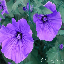

In [ ]:
import matplotlib.pyplot as plt
me=image_label_pairs[2][0]*127.5+127.5
# image_label_pairs[0][0]
print(image_label_pairs[2][1])
Image.fromarray(me.astype(np.uint8))


In [ ]:
from random import shuffle
shuffle(image_label_pairs)

In [ ]:
image_label_pairs[0][0]

array([[[-0.3960784 , -0.372549  , -0.94509804],
        [-0.3490196 , -0.3490196 , -0.8901961 ],
        [-0.23921567, -0.17647058, -0.77254903],
        ...,
        [-0.47450978, -0.92156863, -0.23137254],
        [-0.5058824 , -0.99215686, -0.21568626],
        [-0.64705884, -0.92941177, -0.3960784 ]],

       [[-0.4352941 , -0.38823527, -0.8666667 ],
        [-0.3960784 , -0.35686272, -0.8666667 ],
        [-0.27843136, -0.27058822, -0.81960785],
        ...,
        [-0.31764704, -0.90588236, -0.09019607],
        [-0.52156866, -0.8901961 , -0.23921567],
        [-0.64705884, -0.64705884, -0.45098037]],

       [[-0.44313723, -0.38039213, -0.8901961 ],
        [-0.38823527, -0.3490196 , -0.8901961 ],
        [-0.27843136, -0.23921567, -0.85882354],
        ...,
        [-0.3490196 , -0.7019608 , -0.1372549 ],
        [-0.49019605, -0.67058825, -0.31764704],
        [-0.62352943, -0.8039216 , -0.372549  ]],

       ...,

       [[-0.77254903, -0.67058825, -0.9764706 ],
        [-0

In [ ]:

    # def load_model(self, model_dir_path):
    #     config_file_path = DCGan.get_config_file_path(model_dir_path)
    #     self.config = np.load(config_file_path).item()
    #     self.img_width = self.config['img_width']
    #     self.img_height = self.config['img_height']
    #     self.img_channels = self.config['img_channels']
    #     self.random_input_dim = self.config['random_input_dim']
    #     self.text_input_dim = self.config['text_input_dim']
    #     self.glove_source_dir_path = self.config['glove_source_dir_path']
    #     self.create_model()
    #     self.glove_model.load(self.glove_source_dir_path, embedding_dim=self.text_input_dim)
    #     self.generator.load_weights(DCGan.get_weight_file_path(model_dir_path, 'generator'))
    #     self.discriminator.load_weights(DCGan.get_weight_file_path(model_dir_path, 'discriminator'))

In [ ]:
gan = DCGanV3()
gan.img_width = img_width
gan.img_height = img_height
gan.img_channels = img_channels
gan.random_input_dim = 100
gan.glove_source_dir_path = '/content/drive/MyDrive/Text-to-Image/keras-text-to-image/demo/very_large_data'

## train and generate

In [ ]:
# from tensorflow import keras

# gener= gan.generator
# keras.utils.plot_model(gener, "my_first_model.png")

In [ ]:
batch_size = 64
epochs = 10

In [ ]:
current_dir= "/content/drive/MyDrive/Text-to-Image/keras-text-to-image/demo"
model_dir_path = current_dir + '/models1'
gan__pre = DCGanV3()
gan__pre.img_width = img_width
gan__pre.img_height = img_height
gan__pre.img_channels = img_channels
gan__pre.random_input_dim = 100
gan__pre.glove_source_dir_path = '/content/drive/MyDrive/Text-to-Image/keras-text-to-image/demo/very_large_data'
gan__pre.load_model(model_dir_path)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 100)          10100       ['input_9[0][0]']                
                                                                                                  
 dense_13 (Dense)               (None, 1024)         103424      ['input_10[0][0]']               
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


                                                                                                  
 activation_16 (Activation)     (None, 1124)         0           ['concatenate_4[0][0]']          
                                                                                                  
 dense_14 (Dense)               (None, 32768)        36864000    ['activation_16[0][0]']          
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 32768)       131072      ['dense_14[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_17 (Activation)     (None, 32768)        0           ['batch_normalization_2[0][0]']  
                                                                                                  
 reshape_2

In [ ]:
# gan.fit(model_dir_path=model_dir_path, image_label_pairs=image_label_pairs1,
#             snapshot_dir_path=current_dir + '/data/snapshots',
#             snapshot_interval=10,
#             batch_size=batch_size,
#             epochs=epochs)

In [ ]:
gan__pre.fit(model_dir_path=model_dir_path, image_label_pairs=image_label_pairs,
            snapshot_dir_path=current_dir + '/data/snapshots',
            snapshot_interval=10,
            batch_size=batch_size,
            epochs=epochs,cont=True)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_24 (Dense)               (None, 100)          10100       ['input_17[0][0]']               
                                                                                                  
 dense_25 (Dense)               (None, 1024)         103424      ['input_18[0][0]']               
                                                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


 input_18 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_24 (Dense)               (None, 100)          10100       ['input_17[0][0]']               
                                                                                                  
 dense_25 (Dense)               (None, 1024)         103424      ['input_18[0][0]']               
                                                                                                  
 concatenate_8 (Concatenate)    (None, 1124)         0           ['dense_24[0][0]',               
                                                                  'dense_25[0][0]']               
                                                                                                  
 activation_32 (Activation)     (None, 1124)         0           ['concatenate_8[0][0]']          
          

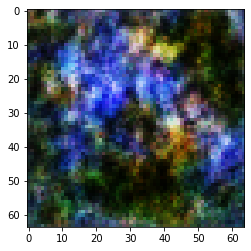

In [ ]:
generated_image = gan__pre.generate_image_from_text("the petals on this flower are pink with dark pink veins.")
generated_image=np.array(generated_image)
plt.imshow(generated_image)
# generated_image


In [ ]:

for i in range(10,11):
        image_label_pair = image_label_pairs[i]
        normalized_image = image_label_pair[0]
        text = image_label_pair[1]
        print(text)

        image = img_from_normalized_img(normalized_image)
        # image.save(current_dir + '/data/output/' + DCGanV3.model_name + '-generated-' + str(i) + '-0.png')
        mes=[]
        for j in range(3):
            generated_image = gan__pre.generate_image_from_text(text)
            me=np.array(generated_image)
            mes.append(me)
            # from PIL import Image # Notice the 'from PIL' at the start of the line

            # im = Image.new("RGB", (200, 30), "#ddd")
            # im.save("image.png")
            # generated_image.save(current_dir + '/data/output/' + DCGanV3.model_name + '-generated-' + str(i) + '-' + str(j) + '.png')


a yellow and orange flower with layered narrow petals and a large center of stamen.
this flower is yellow and red in color, with petals that are striped in the center.
this flower has thick orange and yellow petals as its main feature.
these two flowers has pretty yellow and orange petals with tall green leaves
this flower has petals that are yellow with orange lines
this flower has many long bright yellow petals with bright orange at the center of each petal.
this flower has pointed yellow petals with red lines on them
petals have yellow edges and orange middles with many yellow anther.
there are many yellow filaments in the center of mostly yellow leaves with a dark orange center running through them.
this flower has petals with slightly pointed tips, yellow edges, and red stripes down the middle.



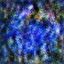

In [ ]:
Image.fromarray(mes[0].astype(np.uint8))

In [ ]:
# with open("/content/drive/MyDrive/Text-to-Image/keras-text-to-image-illustrations/demo/models/dc-gan-v3-config.txt","r") as f:
#   me=f.read()
# me

"�NUMPY\x01\x00v\x00{'descr': '|O', 'fortran_order': False, 'shape': (), }                                                               \n�\x03cnumpy.core.multiarray\n_reconstruct\nq\x00cnumpy\nndarray\nq\x01K\x00�q\x02C\x01bq\x03�q\x04Rq\x05(K\x01)cnumpy\ndtype\nq\x06X\x02\x00\x00\x00O8q\x07���q\x08Rq\t(K\x03X\x01\x00\x00\x00|q\nNNNJ����J����K?tq\x0bb�]q\x0c}q\n(X\t\x00\x00\x00img_widthq\x0eK@X\n\x00\x00\x00img_heightq\x0fK@X\x10\x00\x00\x00random_input_dimq\x10KdX\x0e\x00\x00\x00text_input_dimq\x11KdX\x0c\x00\x00\x00img_channelsq\x12K\x03X\x15\x00\x00\x00glove_source_dir_pathq\x13X\x11\x00\x00\x00./very_large_dataq\x14uatq\x15b."

In [ ]:
import numpy as np
np.load("/content/drive/MyDrive/Text-to-Image/keras-text-to-image-illustrations/demo/models/dc-gan-v3-config.npy",allow_pickle=True)

OSError: ignored

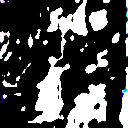

In [ ]:
generated_image

In [ ]:
# image_label_pairs[2][]
image_label_pairs[0][1]

'a flower that has vivid orange petals and a yellow center\nthis flower is orange and green in color, with petals that are curled backward.\nthis flower has five rounded red petals which are large and slightly ruffled.\nthis flower has petals that are orange with red anthers.\nthis flower has a large orange flower and a bright green stigma\nthis orange, red and yellow flower has rounded petals and a green pedicel.\nthis wet, orange flower has 5 large, round petals with a prominent texture, and lots of small green stamen coming out of the center with orange filaments.\nbright orange flower with alternate sepals, green colored androecium and gynoecium\nthis flower has petals that are red and has green stamen\nlarge five bright orange petals, bright yellow ovule, with the same color orange stamens.\n'

In [ ]:
mes[0].shape

(64, 64, 3)

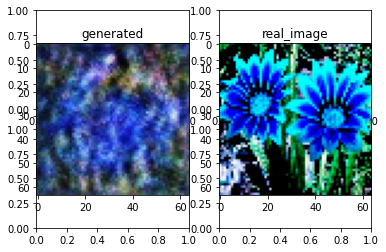

In [ ]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 5))


f, axarr = plt.subplots(2,2)
f.add_subplot(1,2,1)
plt.title("generated")
plt.imshow(mes[0])

f.add_subplot(1,2,2)
plt.title("real_image")
plt.imshow((image_label_pairs[10][0])) 


In [ ]:
image_label_pairs[13][1]

"the flower shown has petals which are yellow and orange with a yellow stamen\na flower with red and yellow petals and brownish orange anther filaments.\nthis flower is yellow and black in color, with petals that are pointed at the tips.\nthis flower has petals that are orange and yellow with short stamen\nthis flower's wide yellow center is surrounded by several layers of yellow petals with red centers.\na large yellow flower with separated petals that are arranged in disc like manner around stamen\nthis flower has tapered yellow petals which have vertical orange center stripes.\nthis flower is yellow and red in color, and has petals that are oval shaped.\nthis flower has yellow petals with orange lines and many stamen\nthis flower has three rows of petals that are yellow on the edges with orange in the center.\n"

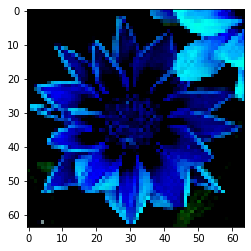

In [ ]:
plt.imshow(image_label_pairs[13][0])

In [ ]:
image_label_pairs[2][0].shape

(64, 64, 3)